# Practical Session 4 - Deep Learning with PyTorch
In this session we will start with our toy task again.
Remember how we solved it with an MLP in the first class ?
We used scikit-learn, a one-liner but without control over what was happening.

We will start by implementing the model in Pytorch, in a basic way.

Then we will work our way to making our code looks like a real Pytorch code.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

np.random.seed(20) # set the seed for reproducibility


def base_function(x): 
    y = 1.3 * x ** 3 - 3 * x ** 2 + 3.6 * x + 6.9
    return y

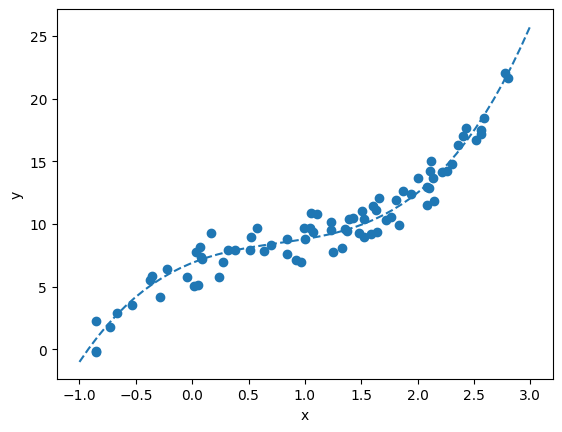

In [16]:

low, high = -1, 3 # the range of x
n_points = 80 # the number of points to sample

# Get the values
xs = np.random.uniform(low, high, n_points) # sample x values
ys_noise = np.random.normal(size=len(xs)) # sample noise
sample_ys = base_function(xs) # get the y values
noisy_sample_ys = sample_ys + ys_noise # add the noise

# Plot the hidden function
lsp = np.linspace(low, high) # the x values to plot the function
true_ys = base_function(lsp) # the y values of the function
plt.plot(lsp, true_ys, linestyle='dashed') 

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We used the following command to fit the regressor last time :
"from sklearn.neural_network import MLPRegressor
 mlp_model = MLPRegressor(max_iter=5000)"

By default, the MLP Regressor makes the following computational graph :
- input gets multiplied by a matrix with 100 parameters, and an additional parameter is added to each values, giving 100 outputs y (shape = (n_samples, 100))
- ReLU is applied to each of these outputs (shape = (n_samples, 100)). The relu function is implemented in PyTorch with torch.nn.functional.relu(x)
- Then this value is multiplied by a matrix to produce a scalar output (again 100 parameters) (shape = (n_samples, 1)) and shifted by an offset.

A quick reminder on matrix multiplication : it is an operation that combines one matrix A of shape (m,n) and a matrix B of shape (n,p) into a matrix C of shape (m,p). In PyTorch (and NumPy), you need to call torch.matmul(A,B) to make this computation.

To make the two big multiplications, we will use one torch tensor of 100 parameters for each multiplication, with the appropriate shape.Create random starting tensors of parameters.

Then implement the asked computation to produce our output from our input. You should debug the operations by ensuring the shapes are correct.

In [17]:
# First create the parameters with small random initial values.
# We need to mention that we want to compute a gradient
# I provide you with the example for the first one, fill the others :
w1 = torch.normal(mean=0., std=0.1, size=(1, 100), requires_grad=True) 
b1 = torch.normal(mean=0., std=0.1, size=(1, 100), requires_grad=True) 
w2 = torch.normal(mean=0., std=0.1, size=(100, 1), requires_grad=True)
b2 = torch.normal(mean=0., std=0.1, size=(1, 1), requires_grad=True)

In [18]:
# Then define the function
def f(x, weight1=w1, bias1=b1, weight2=w2, bias2=b2): 
    step1  = torch.matmul(x, weight1) # matrix multiplication
    step2 = torch.add(step1, bias1) # addition
    step3 = torch.relu(step2) # ReLU # rectified linear unit
    step4 = torch.matmul(step3, weight2)
    out = torch.add(step4, bias2)
    return out


# Just to be sure everything runs, we make an inference on an example input of 6 random values
sample_input = torch.ones(size=(6, 1)) # create a tensor of size 6x1 with all values equal to 1
f(sample_input).shape # make an inference on the input and check the shape of the output

torch.Size([6, 1])

Now we will mostly use last class optimization procedure to train our network using Pytorch
Fill out the learning loop, inspired by last time's class.
Then plot the resulting model

In [19]:
# Also set up the data
# Check that when doing inference on the data, we get an output tensor of shape (80,1)
# Call us if it is not the case, there is something ~ subtle and not interesting
torch_xs = torch.from_numpy(xs).float()[:, None] # convert the numpy array to a tensor of shape (80,1)
torch_noisy_ys = torch.from_numpy(noisy_sample_ys).float()[:, None] # convert the numpy array to a tensor of shape (80,1)
f(torch_xs).shape # make an inference on the input and check the shape of the output

torch.Size([80, 1])

In [20]:
# Now like last time, let us define an optimizer and give the parameters to it.
n_iter = 2000 # the number of iterations
opt = torch.optim.Adam([w1, b1, w2, b2], lr=0.01) # the optimizer with the parameters to optimize and the learning rate

In [21]:
# Loop over the data, and implement optimization as discussed in class
for i in range(n_iter):
    # loss = torch.mean((f(torch_xs) - torch_noisy_ys) ** 2)
    # loss.backward()
    # opt.step()
    # if i % 10 == 0:
    #     print(i, loss.item())

    loss_fn = torch.nn.MSELoss() # mean squared error loss
    loss = loss_fn(f(torch_xs), torch_noisy_ys) # compute the loss
    loss.backward() # compute the gradients
    opt.step() # update the parameters
    if i % 10 == 0: # print the loss every 10 iterations
        print(i, loss.item()) 
        
    opt.zero_grad() # zero the gradients

0 117.1247329711914
10 69.75019836425781
20 15.327199935913086
30 6.511110782623291
40 3.8315021991729736
50 3.373345136642456
60 2.771577835083008
70 2.7741968631744385
80 2.6352975368499756
90 2.590292453765869
100 2.5436007976531982
110 2.485138416290283
120 2.4257571697235107
130 2.366790294647217
140 2.310868978500366
150 2.261258602142334
160 2.2166428565979004
170 2.177504301071167
180 2.1435539722442627
190 2.1119930744171143
200 2.0810160636901855
210 2.0487444400787354
220 2.0147438049316406
230 1.976808786392212
240 1.9335622787475586
250 1.8837544918060303
260 1.8253791332244873
270 1.7601242065429688
280 1.6923545598983765
290 1.6268495321273804
300 1.5646026134490967
310 1.503680944442749
320 1.4464819431304932
330 1.3968489170074463
340 1.3519141674041748
350 1.3103704452514648
360 1.2748289108276367
370 1.246995449066162
380 1.2202188968658447
390 1.195924997329712
400 1.1766927242279053
410 1.1609838008880615
420 1.1453548669815063
430 1.1234216690063477
440 1.10753691

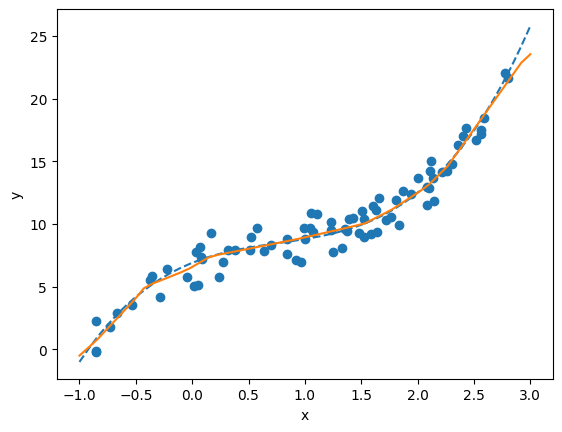

In [22]:
# Let's plot our trained model
torch_lsp = torch.from_numpy(lsp).float()[:, None] # convert the numpy array to a tensor of shape (80,1)
predicted_ys = f(torch_lsp).detach().numpy() # make an inference on the input and check the shape of the output

plt.plot(lsp, true_ys, linestyle='dashed') # Plot the hidden function
plt.plot(lsp, predicted_ys) # Plot the learned function

# Plot the samples
plt.scatter(xs, noisy_sample_ys) 
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Congratulations, you have coded yourself a MLP model ! We have used the computation graph framework.


Now let us make our code prettier (more Pytorch) and more efficient.
First let us refactor the model in the proper way it should be coded, by using the torch.nn.Module class.
You should add almost no new code, just reorganize the one above into a class.

In [23]:
from torch.nn import Module, Parameter # import the base class for all neural network modules and the class for the parameters


class MyOwnMLP(Module): # inherit from the base class
    def __init__(self): # define the constructor
        super(MyOwnMLP, self).__init__() # call the constructor of the base class
        self.w1 = Parameter(torch.normal(mean=0., std=0.1, size=(1, 100))) # define the parameters
        self.b1 = Parameter(torch.normal(mean=0., std=0.1, size=(1, 100))) 
        self.w2 = Parameter(torch.normal(mean=0., std=0.1, size=(100, 1)))
        self.b2 = Parameter(torch.normal(mean=0., std=0.1, size=(1, 1)))
        

    def forward(self, x): # define the forward pass
        step1  = torch.matmul(x, self.w1) # matrix multiplication
        step2 = torch.add(step1, self.b1) # addition
        step3 = torch.relu(step2) # ReLU # rectified linear unit
        step4 = torch.matmul(step3, self.w2)
        out = torch.add(step4, self.b2)
        return out


model = MyOwnMLP() # create an instance of the model
out = model(torch_xs) # make an inference on the input and check the shape of the output
out.shape # check the shape of the output

torch.Size([80, 1])

Now we are good to also make the data iteration process look like Pytorch code !

We need to define a Dataset object. Once we have this, we can use it to create a DataLoader object

In [24]:
from torch.utils.data import Dataset, DataLoader # import the base class for all datasets and the class for the data loader


class CustomDataset(Dataset): # inherit from the base class
    def __init__(self, data_x, data_y): # define the constructor
        self.data_x = data_x # store the data
        self.data_y = data_y 

    def __len__(self): # define the length function
        length = len(self.data_x) # get the length of the data
        return length # return the length

    def __getitem__(self, index): # define the get item function
        # Get the x and y at a given position (index) in the data
        x = self.data_x[index] 
        y = self.data_y[index]
        return x, y

In [25]:
# Loop and wait for each data point in PyTorch
dataset = CustomDataset(data_x=torch_xs, data_y=torch_noisy_ys) # create an instance of the dataset
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=0) # create an instance of the data loader
start = time.time() # start the timer
for point in dataloader: # loop over the data
    pass
print('Done in pytorch : ', time.time() - start)

Done in pytorch :  0.002103090286254883


The last thing missing to make our pipeline truly Pytorch is to use a GPU.

In Pytorch it is really easy, you just need to 'move' your tensors to a 'device'.
You can test if a gpu is available and create the appropriate device with the following lines:

In [26]:
device = 'gpu' if torch.cuda.is_available() else 'cpu' # check if cuda is available
torch_xs = torch_xs.to(device) # move the data to the device

Now we finally have all the elements to make an actual Pytorch complete pipeline !

Create a model, and try to put it on a device.
Create an optimizer with your model's parameters
Make your data into a dataloader

Then use two nested for loops : one for 100 epochs, and in each epoch loop over the dataloader
    Inside the loop, for every batch first put the data on the device
    Then use the semantics of above :
        - model(batch)
        - loss computation and backward
        - gradient step and zero_grad

In [27]:
n_epochs = 200 # the number of epochs

model = MyOwnMLP() # create an instance of the model
model = model.to(device) # move the model to the device
opt = torch.optim.Adam(model.parameters(), lr=0.01) # the optimizer with the parameters to optimize and the learning rate

dataset = CustomDataset(data_x=torch_xs, data_y=torch_noisy_ys) # create an instance of the dataset
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=0) # create an instance of the data loader

for epoch in range(n_epochs): # loop over the epochs
    for batch_x, batch_y in dataloader: # loop over the data
        # Don't forget to send to device, the rest is similar to what we had above
        batch_x = batch_x.to(device) 
        batch_y = batch_y.to(device) 
        opt.zero_grad() 
        loss = torch.mean((model(batch_x) - batch_y) ** 2) # compute the loss
        loss.backward() # compute the gradients
        opt.step() # update the parameters
    if epoch % 10 == 0: # print the loss every 10 iterations
        print(epoch, loss.item())

# Let's plot our trained model
torch_lsp = torch.from_numpy(lsp).float()[:, None] # convert the numpy array to a tensor of shape (80,1)

# To easily use the trained model we need to send it back to cpu at the end
model = model.to('cpu') # move the model to the cpu

0 142.20462036132812
10 5.116946220397949
20 4.73479700088501
30 4.276891708374023
40 3.766317844390869
50 3.2547287940979004
60 2.778569221496582
70 2.346055746078491
80 1.9840961694717407
90 1.6932464838027954
100 1.509013056755066
110 1.3968064785003662
120 1.3320329189300537
130 1.2797377109527588
140 1.2362778186798096
150 1.2087101936340332
160 1.1814072132110596
170 1.1669217348098755
180 1.1457247734069824
190 1.129463791847229


We finally can plot the last model

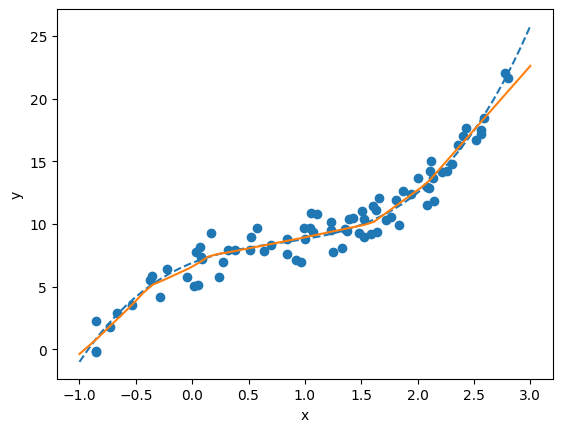

In [28]:
predicted_ys = model(torch_lsp).detach().numpy() # make an inference on the input and check the shape of the output

plt.plot(lsp, true_ys, linestyle='dashed') 
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()